In [361]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
import glob

In [16]:
files = glob.glob('ks_spec/*')

In [17]:
files = files

In [18]:
def get_spectrum(file):
    path = file
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        print('Spectrum file missing...')
        return
    return lam,flux,fluxsig

In [19]:
interpfluxs = [];
sigs = [];
types = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(files))):
    spec = get_spectrum(files[i])
    lam  = spec[0]
    flux = spec[1]
    sig = spec[2]
    func2 = interp1d(lam,sig,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpsig = func2(lamgrid)
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)
    sigs.append(interpsig)
    types.append(files[i].split('_')[2])
spectra = np.asarray(interpfluxs)
types = np.asarray(types)

100%|██████████| 4958/4958 [00:55<00:00, 89.95it/s] 


In [35]:
pixels = np.arange(0,4000)
continuum = (pixels > 2900) + (pixels < 2400)*(pixels > 1200) + (pixels < 700)*(pixels > 550) \
            + (pixels < 35)*(pixels > 10) + (pixels < 225)*(pixels > 205)
def adapted_ch_cont(array,continuum,sigarray = None):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],10)
    cont = np.polynomial.chebyshev.chebval(lamgrid,p)
    contcorr = spec / cont
    if sigarray is not None:
        stdev = np.sqrt(1.0/sigarray)
        contsigarray = stdev / cont
        normivar = (1.0/contsigarray)**2
        return contcorr,normivar
    return contcorr

def norm_dataspec(array,sigarray=None):
    contcorr = adapted_ch_cont(array,continuum,sigarray)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    #contcorr[where] = 1
    return contcorr

In [36]:
normspectra = [];
for i in tqdm(range(len(spectra))):
    normspectra.append(norm_dataspec(spectra[i]))
normspectra = np.asarray(normspectra)

100%|██████████| 4958/4958 [00:03<00:00, 1387.68it/s]


In [107]:
where = (normspectra > 1.5) + (normspectra < 0) + np.isnan(normspectra)
normspectra[where] = 1

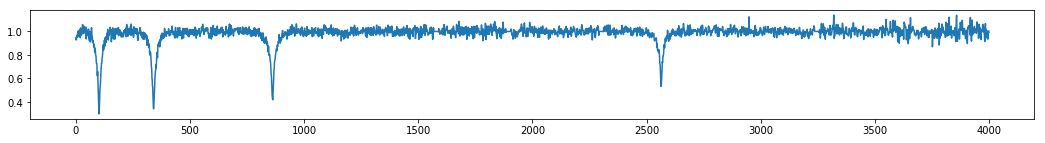

In [108]:
plt.figure(figsize = (18,2))
plt.plot(normspectra[np.random.randint(0,len(normspectra))])

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [371]:
spec_class = np.zeros(len(normspectra))
anysda = ['sdA' in types[i] for i in range(len(types))]
spec_class[anysda] = 1
t = spec_class.astype(int)

In [372]:
scores = [];
window = 5 # radius. Actual window is twice this
pixelrange = np.arange(window, 4000 - window)

for pixel in tqdm(pixelrange):
    X = normspectra[:,(pixel-window):(pixel+window)]
    clf = LogisticRegression(solver = 'newton-cg', class_weight = 'balanced')
    clf.fit(X,t)
    scores.append(clf.score(X,t))

Text(0.5, 0, 'Wavelength (A)')

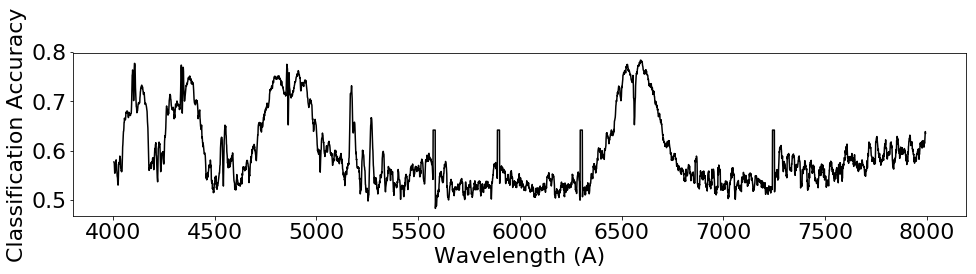

In [374]:
plt.figure(figsize = (16,3))
plt.plot(lamgrid[window:-window],scores,'k')
plt.ylabel('Classification Accuracy')
plt.xlabel('Wavelength (A)')

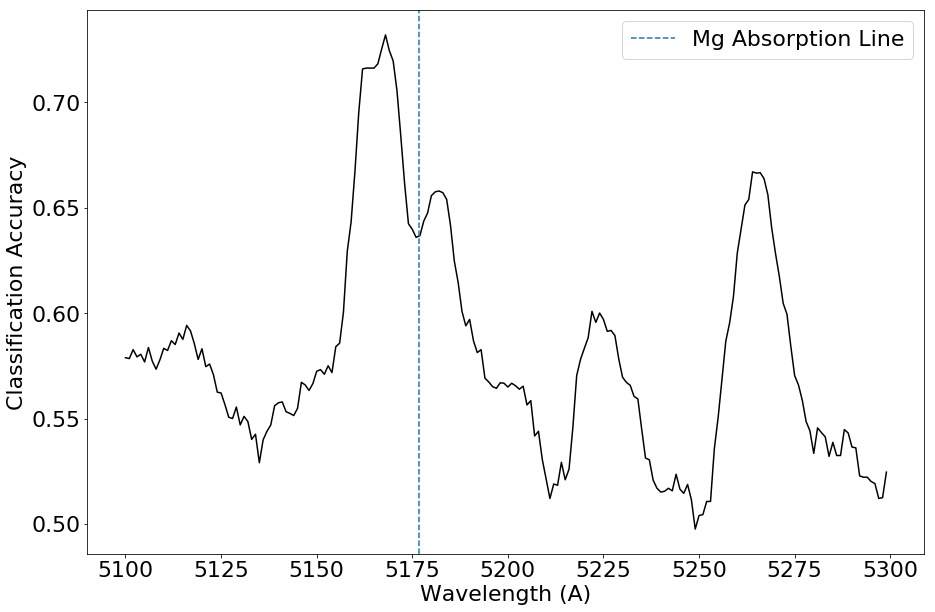

In [388]:
low = 1100
up = 1300
plt.plot(lamgrid[low:up],scores[low:up],'k')
plt.ylabel('Classification Accuracy')
plt.xlabel('Wavelength (A)')
plt.axvline(5176.7, label = 'Mg Absorption Line', linestyle = '--')
plt.legend()

In [ ]:
scores = [];
window = 5 # radius. Actual window is twice this
pixelrange = np.arange(window, 4000 - window)

for pixel in tqdm(pixelrange):
    X = normspectra[:,(pixel-window):(pixel+window)]
    clf = LogisticRegression(solver = 'newton-cg', class_weight = 'balanced')
    clf.fit(X,t)
    scores.append(clf.score(X,t))